In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from transformers import (
    pipeline, 
    AutoModelForCausalLM, 
    AutoProcessor
)
from tensorflow.keras.preprocessing.image import  load_img, img_to_array
import matplotlib.pyplot as plt
from textwrap import wrap
from pythainlp import translate

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Load Model
checkpoint = "microsoft/git-base"
# pipe = pipeline("image-to-text", model=checkpoint, device=0)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
processor = AutoProcessor.from_pretrained(checkpoint)
print(f'n params: {sum(p.numel() for p in model.parameters())}')

n params: 176619066


In [13]:
IMG_FOLDER = 'CodeCit\Lab3-Machine-Learning\Vision\ex03_img_caption_2\Images'
test_df = pd.read_csv("captions.txt", delimiter=",", header=0)

In [14]:
# en2th = translate('en', 'th') # translation model

In [20]:
def process_images_from_folder(img_folder, model, processor, en2th=None, device='cuda'):
    # สร้าง DataFrame เพื่อเก็บผลลัพธ์
    result_df = pd.DataFrame(columns=["image_id", "caption"])
    # อ่านไฟล์ทั้งหมดในโฟลเดอร์
    image_files = [f for f in os.listdir(img_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for i, image_file in enumerate(tqdm(image_files)):
        img_path = os.path.join(img_folder, image_file)
        try:

            img = Image.open(img_path).convert('RGB')
            pixel_values = processor(images=img, return_tensors='pt').to(device).pixel_values
            gen_ids = model.generate(pixel_values=pixel_values, max_length=50)
            en_cap = processor.batch_decode(gen_ids, skip_special_tokens=True)[0]

            # # แปลคำบรรยายเป็นภาษาไทย
            # th_cap = en2th.translate(en_cap)

            result_df = pd.concat([result_df, pd.DataFrame({"image_id": [image_file], "caption": [en_cap]})], ignore_index=True)
            print(f"{i}: | Caption: {en_cap}")
            print("--" * 20)

        except Exception as e:
            print(f"Error processing file {image_file}: {e}")

    return result_df

In [24]:
result_df = process_images_from_folder('Images/', 
                                       model=model, 
                                       processor=processor, 
                                       device=device)

  0%|          | 0/8091 [00:00<?, ?it/s]

0: | Image: 1000268201_693b08cb0e.jpg | Caption: little girl in pink dress
----------------------------------------
1: | Image: 1001773457_577c3a7d70.jpg | Caption: the dog is black and white
----------------------------------------
2: | Image: 1002674143_1b742ab4b8.jpg | Caption: girl painting a rainbow in the grass
----------------------------------------
3: | Image: 1003163366_44323f5815.jpg | Caption: man laying on a bench
----------------------------------------
4: | Image: 1007129816_e794419615.jpg | Caption: man wearing a hat
----------------------------------------
5: | Image: 1007320043_627395c3d8.jpg | Caption: girl in pink
----------------------------------------
6: | Image: 1009434119_febe49276a.jpg | Caption: my dog running in the grass
----------------------------------------
7: | Image: 1012212859_01547e3f17.jpg | Caption: a dog playing with a ball
----------------------------------------
8: | Image: 1015118661_980735411b.jpg | Caption: a boy running on the sidewalk
----

In [5]:
result_df = pd.read_csv ("captions_result.csv")

In [6]:
result_df.head()

,image_id,caption
0,1000268201_693b08cb0e.jpg,little girl in pink dress
1,1001773457_577c3a7d70.jpg,the dog is black and white
2,1002674143_1b742ab4b8.jpg,girl painting a rainbow in the grass
3,1003163366_44323f5815.jpg,man laying on a bench
4,1007129816_e794419615.jpg,man wearing a hat


In [9]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(25, 25))
    n = 0
    for i in range(min(15, len(temp_df))):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        image = readImage(f"Images/{temp_df.image_id[i]}")
        plt.imshow(image)
        
        if temp_df.shape[1] == 3:
            title_text = f"Caption: {temp_df.caption[i]}\n Idx: {temp_df.idx_sequence[i]}"
        else:
            title_text = temp_df.caption[i]  
        
        plt.title("\n".join(wrap(title_text, 40)))  
        plt.axis("off")


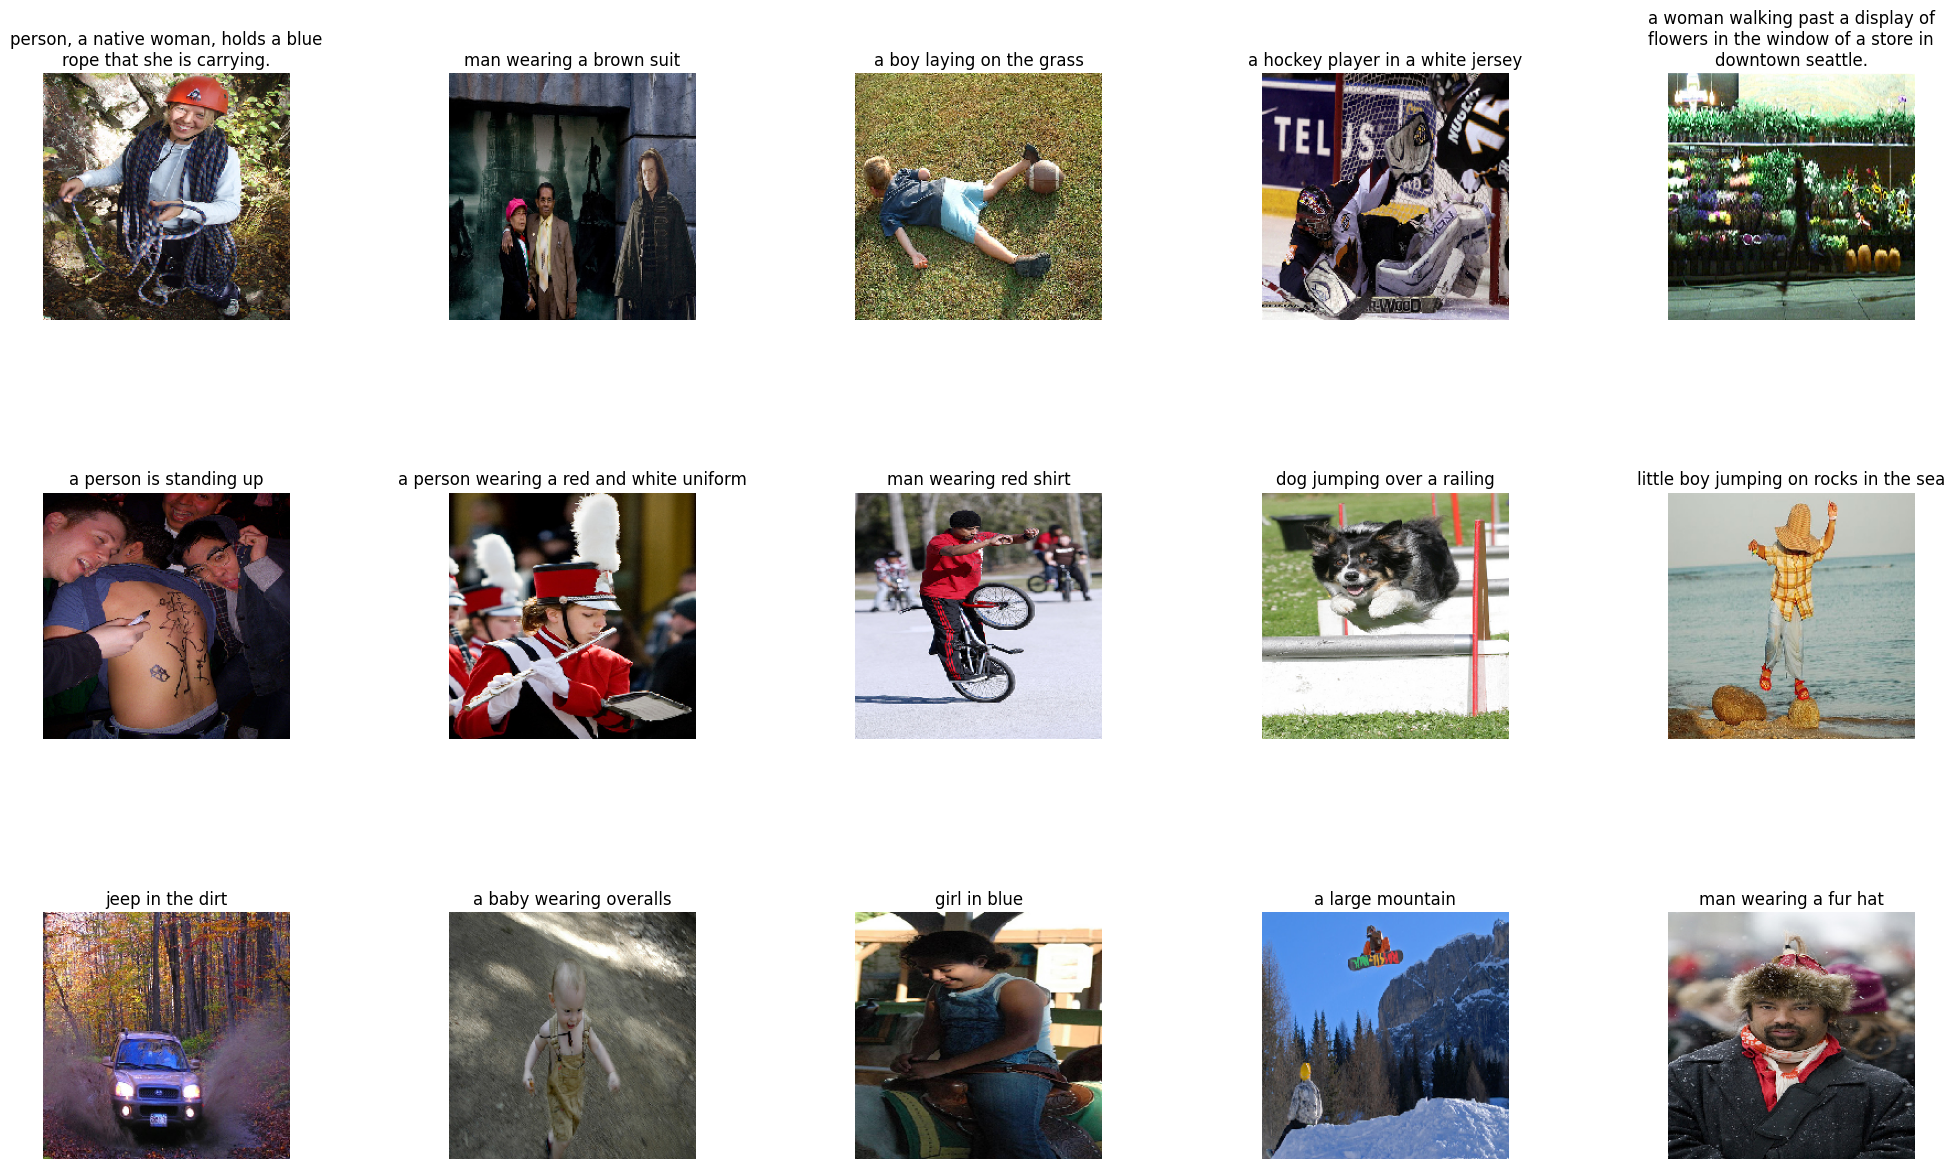

In [15]:
display_images(result_df.sample(15))

In [7]:
result_df.to_csv("captions_result.csv", index=False)